In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

# Import Dataset

In [ ]:
xls_path = pd.ExcelFile('/Users/dileepsathyan/Documents/GitHub/Assignments/Vroom Virtusa/Analytics_Dataset.xlsx')
df_car_sales   = pd.read_excel(xls_path, 'car_sales')
df_car_details = pd.read_excel(xls_path, 'car_details')
df_car_claims  = pd.read_excel(xls_path, 'car_claims')

In [ ]:
df_car_sales.head()

In [ ]:
df_car_details.head()

In [ ]:
df_car_claims.head()

# Data Cleaning

## 1. Car_Sales Dataframe Cleaning

In [ ]:
df_car_sales.shape

In [ ]:
df_car_sales.drop_duplicates(inplace=True)
df_car_sales.shape

In [ ]:
# Delete the transport dates for the rows with transport_to_merchant == 0

df_car_sales['transport_date'].loc[(df_car_sales['transport_to_merchant'])== 0] = np.NaN
df_car_sales

#### Convert to right datatypes

In [ ]:
# df_car_sales['car_id_sales'] = df_car_sales['car_id_sales'].astype('str')
# df_car_sales['merchant_id'] = df_car_sales['merchant_id'].astype('str')

df_car_sales['selling_date'] = pd.to_datetime(df_car_sales['selling_date'])
df_car_sales['payment_date'] = pd.to_datetime(df_car_sales['payment_date'])
df_car_sales['transport_date'] = pd.to_datetime(df_car_sales['transport_date'])

# Rename primary column
df_car_sales.rename(columns={'car_id_sales': 'car_id'}, inplace=True)

df_car_sales.info()

In [ ]:
# Notice that the same car_ids are repeated for different merchant_ids

df_car_sales[df_car_sales['car_id'] == 5805619905]

In [ ]:
# There are merchant_ids who bought so many cars.

df_car_sales.merchant_id.value_counts()

In [ ]:
#### As long as we have no clarity on the correct Merchant who bought a car, it doesnt matter which record we delete.
#### Lets keep car_id only once and delete all following records for the sale.

df_car_sales = df_car_sales.drop_duplicates(subset='car_id', keep="first")
df_car_sales.info()

### Handle missing datapoints in Car_Sales

In [ ]:
# For each country, find the average days for transport from the payment_date

df_cs_temp = df_car_sales[df_car_sales['transport_date'].notna()]
df_cs_temp['days_payment_to_transp'] = (df_cs_temp['transport_date'] - df_cs_temp['payment_date']).dt.days
df_cs_temp

In [ ]:
avr_days_to_transp = df_cs_temp.groupby(['country'])['days_payment_to_transp'].mean().round()
avr_days_to_transp= avr_days_to_transp.to_dict()
avr_days_to_transp

In [ ]:
# Subset the cars trasp_to_merchant to fill the missing transport_date for them.

df_cs_transp = df_car_sales[df_car_sales['transport_to_merchant']==1]
df_cs_transp['days_to_transp'] = pd.to_timedelta(df_cs_transp['country'].map(avr_days_to_transp), 'days')
df_cs_transp['transport_date'] = df_cs_transp['transport_date'].fillna(df_cs_transp['payment_date'] + df_cs_transp['days_to_transp'])
df_cs_transp.info()

In [ ]:
df_cs_transp = df_cs_transp.drop(columns=['days_to_transp'])
df_cs_transp.info()

In [ ]:
# Replace the non-NULL transport_date to original dataframe

idx = df_cs_transp.index
df_car_sales = df_car_sales.drop(idx)
df_car_sales.info()

In [ ]:
# Append the cleaned dataframe to the the original

df_car_sales = df_car_sales.append(df_cs_transp)

# Reset index
df_car_sales.reset_index(drop=True, inplace=True)
df_car_sales.info()

## Car_Details Dataframe Cleaning

In [ ]:
df_car_details.shape

In [ ]:
df_car_details.drop_duplicates(inplace=True)
df_car_details.shape

In [ ]:
df_car_details.info()

#### Convert to right datatypes

In [ ]:
# df_car_details['car_id_details'] = df_car_details['car_id_details'].astype('str')

# Rename primary column
df_car_details.rename(columns={'car_id_details': 'car_id'}, inplace=True)
df_car_details.info()

In [ ]:
## Check for duplicate records of same car_id

df_car_details[df_car_details.groupby('car_id')['car_id'].transform('size') > 1].sort_values(by='car_id').head(20)

In [ ]:
# Subset the records with duplicate car_ids

df_cd_dup = df_car_details[df_car_details.groupby('car_id')['car_id'].transform('size') > 1].sort_values(by='car_id')
df_cd_dup.sort_values(by='car_id').head(10)

In [ ]:
df_cd_dup.shape

In [ ]:
# Remove the duplicated car_ids from original dataframe to make it a deduplicated df.

df_cd_deduped = df_car_details.drop(df_cd_dup.index)
df_cd_deduped.shape

##### Notice from the above subset that fule_type and navigation_system are the 2 fields which cause duplication.

###### 1. Those who differ only by fuel_type, lets keep the first record of each car_id and delete the rest.

In [ ]:
df_cd_dup = df_cd_dup.drop_duplicates(['car_id', 'navigation_system']).sort_values(by='car_id')

df_cd_dup.head(10)

In [ ]:
df_cd_dup.shape

In [ ]:
# Filter the uniques and append to the deduped dataframe & drop the uniques from the df_cd_dup

df_temp = df_cd_dup[df_cd_dup.groupby('car_id')['car_id'].transform('size') == 1]

df_cd_deduped = df_cd_deduped.append(df_temp)
df_cd_dup = df_cd_dup.drop(df_temp.index)
df_cd_dup.head(10)

In [ ]:
df_cd_dup.shape

##### 2. Those who differ only by navigation_system, lets keep the first record of each car_id and delete the rest.

In [ ]:
df_cd_dup = df_cd_dup.drop_duplicates(['car_id', 'fuel_type']).sort_values(by='car_id')

df_cd_dup.head(10)

In [ ]:
# Filter the uniques and append to the deduped dataframe & drop the uniques from the df_cd_dup

df_temp = df_cd_dup[df_cd_dup.groupby('car_id')['car_id'].transform('size') == 1]

df_cd_deduped = df_cd_deduped.append(df_temp)
df_cd_dup = df_cd_dup.drop(df_temp.index)
df_cd_dup.head(10)

In [ ]:
df_cd_dup.shape

###### 3. Those who differ in both navigation_system & fuel_type, lets keep the record with 1100 as nav_system and delete the 0 values.

In [ ]:
df_cd_dup = df_cd_dup[df_cd_dup['navigation_system'] != 0]
df_cd_deduped = df_cd_deduped.append(df_cd_dup)
df_cd_deduped.shape

In [ ]:
df_car_details = df_cd_deduped

# Reset index
df_car_details.reset_index(drop=True, inplace=True)

df_car_details.shape

### Handle Missing datapoints in Car_Details

In [ ]:
df_car_details.info()

In [ ]:
# Notice that radio_system doesnt have any major correlation with the other fields in the dataframe
df_car_details.corr()

In [ ]:
# Hence, fill the missing datapoints in the radio_system with 0 values.

df_car_details['radio_system'].fillna(0, inplace=True)
df_car_details.info()

## Car_Claims Dataframe Cleaning

In [ ]:
df_car_claims.shape

In [ ]:
df_car_claims.drop_duplicates(inplace=True)
df_car_claims.shape

In [ ]:
df_car_claims.info()

#### Convert to right datatypes

In [ ]:
# df_car_claims['car_id_claims'] = df_car_claims['car_id_claims'].astype('str')
# df_car_claims['claim_number'] = df_car_claims['claim_number'].astype('str')

# Rename primary column
df_car_claims.rename(columns={'car_id_claims': 'car_id'}, inplace=True)

df_car_claims.info()

In [ ]:
df_car_claims.head()

In [ ]:
# In case of full_refunds, there cannot be a voucher_amount.
# In other words, if the voucher_amount exists, fix the full_refunds fields values to 0.

idx = df_car_claims[df_car_claims['voucher_amount'].notnull() &
                   (df_car_claims['full_refunds'] == 1) & 
                   (df_car_claims['partial_refunds']== 1)].index

idx

In [ ]:
# Adjusting the full_refunds values to 0 to perfect the dataframe

df_car_claims['full_refunds'][idx] = 0
df_car_claims.loc[idx].head()

In [ ]:
# For the REJECTED & CLOSED_NO_COMPENSATION statuses, set the full_refunds & partial refunds values to 0

idx = df_car_claims[df_car_claims['claim_status'].isin(['REJECTED', 'CLOSED_NO_COMPENSATION'])].index
idx

In [ ]:
# Adjusting the full_refunds values to 0 to perfect the dataframe

df_car_claims['full_refunds'][idx] = 0
df_car_claims['partial_refunds'][idx] = 0
df_car_claims.loc[idx].head()

In [ ]:
df_car_claims['claim_status'].value_counts()

In [ ]:
status_codes = { np.NaN: 0,
                'CREATED': 1,
                'NEW_MISSING_ITEM_CLAIM': 1,
                'NEW': 1,

                'PROOF_NOT_RECEIVED': 2,
                'CLOSED_WAITING_FOR_MORE_PROOF': 3,
                'CLOSED_OVER_TIME_LIMIT': 4,
                'MORE_PROOF_RECEIVED': 5,
                'WAITING_FOR_CLAIMS_TEAM_1_EVALUATION': 6,
                '2ND_EVALUATION_CLAIMS_TEAM_2': 7,
                'WAITING_FOR_CLAIMS_TEAM_2_EVALUATION': 8,
                'WAITING_FOR_CARRIER_FEEDBACK': 9,
                'WAITING_FOR_LEGAL_TEAM': 10,

                'CLOSED_NO_COMPENSATION': 11,
                'REJECTED': 12,

                'MISSING_ITEMS_IN_PROGRESS': 13,
                'CLOSED_ITEMS_FOUND_AND_SENT': 14,

                'WAITING_FOR_SALES_TO_NEGOTIATE_WITH_THE_MERCHANT': 15,
                '2ND_DECISION_WAITING_FOR_SALES_TO_NEGOTIATE_WITH_MERCHANT': 16,
                'WAITING_FOR_LOCAL_OPS_MD_DECISION': 17,
                '2ND_DECISION_WAITING_FOR_LOCAL_OPS_MD_DECISION': 18,

                'CLOSED_CARRIER_WILL_COMPENSATE': 19,

                'CLOSED_WAITING_FOR_MERCHANT_BANK_DETAILS': 20, 
                'CLOSED_WAITING_FOR_CAR_DOCUMENTS_AND_BANK_DETAILS': 21,
                'WAITING_FOR_BANK_DETAILS_VALIDATION': 22,

                'CLOSED_WAITING_FOR_MONEY_TO_BE_SHIPPED_AND_COMPENSATION_TO_BE_RECORDED': 23,
                'CLOSED_WAITING_FOR_COMPENSATION_TO_BE_RECORDED': 24,
                'CLOSED_WAITING_FOR_DOCUMENTS': 25,
                'CLOSED_FULLY_PROCESSED': 26 }

In [ ]:
df_cc = df_car_claims.copy()
df_cc['status_code'] = df_cc['claim_status'].map(status_codes)
# df_cc = df_cc.sort_values(by=['car_id', 'status_code'])
df_cc.head()

In [ ]:
# df_cc.groupby(['car_id'])['status_code'].max()

idx = df_cc.groupby(['car_id'])['status_code'].transform(max) == df_cc['status_code']
df_cc = df_cc[idx]
df_cc.shape

In [ ]:
# Identifying Pending Duplicates in the df

df_cc[df_cc['car_id']== 5149303881]

In [ ]:
df_cc['car_id'].nunique()

In [ ]:
# Subset the records with duplicate car_ids

df_cc_dup = df_cc[df_cc.groupby('car_id')['car_id'].transform('size') > 1].sort_values(by='car_id')
df_cc_dup.head(10)

In [ ]:
df_cc_dup.shape

In [ ]:
# Remove the duplicated car_ids from original dataframe to make it a deduplicated df.

df_cc_deduped = df_cc.drop(df_cc_dup.index)
df_cc_deduped.shape

In [ ]:
df_cc_dup['car_id'].nunique()

In [ ]:
df_cc_deduped['car_id'].nunique()

##### Noticed that there are duplicate records with same claim_status
##### 1. Lets keep the record with voucher_amount for the duplicated records.

In [ ]:
df_cd_dup.shape

In [ ]:
# 1a. Before deleting the rows with NULL voucher_amount, 
#     make sure that no duplicated car_ids have NULL values in both of the rows

df_cc_dup[df_cc_dup['voucher_amount'].isnull()]['car_id'].value_counts()

In [ ]:
df_cc_dup[df_cc_dup['car_id']== 2802433468]

In [ ]:
# Since there exists 1 record which has NULL values in both of its rows, 
# lets first clean it to take 1 row and append to the deduped dataframe.

df_cc_deduped = df_cc_deduped.append(df_cc_dup.loc[[60052]])
df_cc_deduped.shape

In [ ]:
# Now drop the both rows of the car_id from dup dataframe.

df_cc_dup = df_cc_dup.drop([60052, 10175])
df_cc_dup.shape

In [ ]:
df_cc_dup.head()

In [ ]:
df_cc_dup.to_excel('df_cc_dup.xlsx')

In [ ]:
# 1b. Now go on and delete the rows with NULL values in voucher_amount in the duplicated dataframe.

idx = df_cc_dup[df_cc_dup['voucher_amount'].isnull()].index

df_cc_dup = df_cc_dup.drop(idx)
df_cc_dup.shape

In [ ]:
# Append the unique rows to dedupted dataframe

df_temp = df_cc_dup[df_cc_dup.groupby('car_id')['car_id'].transform('size') == 1]
df_cc_deduped = df_cc_deduped.append(df_temp)

# Drop the deduped df from the duplicate dataframe
df_cc_dup = df_cc_dup.drop(df_temp.index)
df_cc_dup.shape

In [ ]:
df_cc_dup.head()

In [ ]:
# 2. Now voucher_amount field contains only valid amounts. Lets keep the rows with max amounts and drop the rest.

idx = df_cc_dup.groupby(['car_id'])['voucher_amount'].transform(max) == df_cc_dup['voucher_amount']
df_cc_dup = df_cc_dup[idx]
df_cc_dup.shape

In [ ]:
# Append all the deduped rows to the 

df_cc_deduped = df_cc_deduped.append(df_cc_dup)
df_car_claims = df_cc_deduped

# Reset index
df_car_claims.reset_index(drop=True, inplace=True)

df_car_claims.shape

In [ ]:
df_car_claims.info()

### Handle missing datapoints in Car_Claims

In [ ]:
# Missing Voucher_Amounts to be filled by 0 values
df_car_claims['voucher_amount'].fillna(0, inplace=True)

# Missing claim_status means there is no claim for the sale. Hence fill in with 'NO_CLAIM_RAISED'
df_car_claims['claim_status'].fillna('NO_CLAIM_RAISED', inplace=True)

# Status_code field is not necessary at this stage. Hence drop the field for now.
df_car_claims.drop('status_code', axis=1, inplace=True)
df_car_claims.info()

# Combine the dataframes to 1

In [ ]:
df_car_sales.shape

In [ ]:
df_car_details.shape

In [ ]:
df_car_claims.shape

In [1213]:
# Merging all the 3 dataframes into 1 master

df_master = df_car_sales.merge(df_car_details, on='car_id').merge(df_car_claims, on='car_id')
df_master.shape

(69551, 23)

In [1214]:
df_master.head()

car_id country  merchant_id selling_date selling_week payment_date  \
0  5785159431      FR          NaN   2021-06-03      2021-22   2021-06-08   
1  9820548955      FR          NaN   2021-08-31      2021-35   2021-09-02   
2  7062041313      DE   10443420.0   2021-05-14      2021-19   2021-05-17   
3  2944034946      ES          NaN   2021-07-21      2021-29   2021-07-29   
4  9307814133      DE          NaN   2021-02-17      2021-07   2021-02-23   

   sell_price  transport_to_merchant transport_date  has_tuning  ...  \
0       11028                      0            NaT           0  ...   
1        8423                      0            NaT           0  ...   
2        5800                      0            NaT           0  ...   
3        4000                      0            NaT           1  ...   
4        4950                      0            NaT           0  ...   

   gear_type  ac_type  xenon_light  navigation_system  radio_system  \
0       1138     1050            0               1100        3534.0   
1       1138     1050            0               1100        1100.0   
2       1141        0            0               1100        3534.0   
3       1138        0            0                  0        3534.0   
4       1141        0            0                  0        3534.0   

   claim_number  full_refunds  partial_refunds voucher_amount     claim_status  
0           NaN             0                0       0.000000  NO_CLAIM_RAISED  
1           NaN             0                0       0.000000  NO_CLAIM_RAISED  
2     C1GW00315             0                0     911.334251         REJECTED  
3           NaN             0                0       0.000000  NO_CLAIM_RAISED  
4           NaN             0                0       0.000000  NO_CLAIM_RAISED  

[5 rows x 23 columns]

# Data Exploration

In [1215]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69551 entries, 0 to 69550
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   car_id                 69551 non-null  int64         
 1   country                69551 non-null  object        
 2   merchant_id            19021 non-null  float64       
 3   selling_date           69551 non-null  datetime64[ns]
 4   selling_week           69551 non-null  object        
 5   payment_date           69551 non-null  datetime64[ns]
 6   sell_price             69551 non-null  int64         
 7   transport_to_merchant  69551 non-null  int64         
 8   transport_date         35172 non-null  datetime64[ns]
 9   has_tuning             69551 non-null  int64         
 10  has_airbags            69551 non-null  int64         
 11  has_alarm_system       69551 non-null  int64         
 12  fuel_type              69551 non-null  int64         
 13  g

In [1216]:
df_master.describe()

car_id   merchant_id     sell_price  transport_to_merchant  \
count  6.955100e+04  1.902100e+04   69551.000000           69551.000000   
mean   5.482666e+09  8.386137e+06    7456.351828               0.505701   
std    2.598456e+09  4.728563e+06    8542.072637               0.499971   
min    1.000145e+09  1.211960e+05       5.000000               0.000000   
25%    3.238701e+09  4.294300e+06    2251.500000               0.000000   
50%    5.464531e+09  8.674186e+06    4824.000000               1.000000   
75%    7.729173e+09  1.236666e+07    9482.500000               1.000000   
max    9.999930e+09  1.676935e+07  173000.000000               1.000000   

         has_tuning   has_airbags  has_alarm_system     fuel_type  \
count  69551.000000  69551.000000      69551.000000  69551.000000   
mean       0.386882      0.842748          0.159149   1010.396759   
std        0.487040      0.364040          0.365818    171.698535   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.000000      1.000000          0.000000   1039.000000   
50%        0.000000      1.000000          0.000000   1040.000000   
75%        1.000000      1.000000          0.000000   1040.000000   
max        1.000000      1.000000          1.000000   1040.000000   

          gear_type      ac_type   xenon_light  navigation_system  \
count  69551.000000  69551.00000  69551.000000       69551.000000   
mean    1138.892971    845.42540    173.110149         402.383862   
std        1.251686    415.52003    398.186022         529.824039   
min     1138.000000      0.00000      0.000000           0.000000   
25%     1138.000000   1049.00000      0.000000           0.000000   
50%     1138.000000   1050.00000      0.000000           0.000000   
75%     1139.000000   1050.00000      0.000000        1100.000000   
max     1141.000000   1050.00000   1089.000000        1100.000000   

       radio_system  full_refunds  partial_refunds  voucher_amount  
count  69551.000000  69551.000000     69551.000000    69551.000000  
mean    1814.948786      0.008440         0.116548      409.185390  
std     1640.071469      0.091481         0.320883     1278.060098  
min        0.000000      0.000000         0.000000        0.000000  
25%        0.000000      0.000000         0.000000        0.000000  
50%     1100.000000      0.000000         0.000000        0.000000  
75%     3534.000000      0.000000         0.000000        0.000000  
max     3534.000000      1.000000         1.000000    50331.039294

In [1217]:
df_master['claim_status'].value_counts()[1:]

# F: Most of the cases (8013) are either REJECTED or CLOSED_NO_COMP at the end.

CLOSED_FULLY_PROCESSED                                                    7824
REJECTED                                                                  4755
CLOSED_NO_COMPENSATION                                                    3258
CREATED                                                                    895
CLOSED_ITEMS_FOUND_AND_SENT                                                758
CLOSED_WAITING_FOR_MORE_PROOF                                              335
PROOF_NOT_RECEIVED                                                         301
WAITING_FOR_SALES_TO_NEGOTIATE_WITH_THE_MERCHANT                           226
WAITING_FOR_LOCAL_OPS_MD_DECISION                                          158
MISSING_ITEMS_IN_PROGRESS                                                  131
2ND_DECISION_WAITING_FOR_SALES_TO_NEGOTIATE_WITH_MERCHANT                   76
NEW                                                                         65
WAITING_FOR_CLAIMS_TEAM_2_EVALUATION                

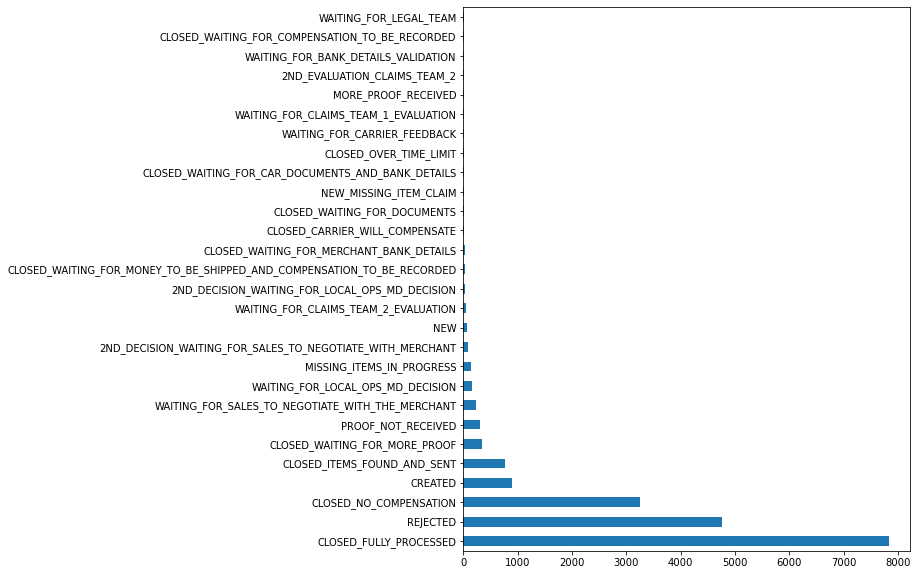

In [1218]:
df_master['claim_status'].value_counts()[1:].plot(kind='barh', figsize=(8, 10))

In [1219]:
# We need to group the statuses into 4 categories

# 1. NOT_CLAIMED
# 2. REJECTED ( REJECTED / CLOSED_NO_COMP)
# 3. CLAIM_PAID
# 4. IN_PROGRESS

# So there is 1 category where the missing items are sent to customers. 
# Need to understand if it costs anything to Vroom..

df_master[df_master['claim_status']== 'CLOSED_ITEMS_FOUND_AND_SENT']['voucher_amount'].sum()

0.0

In [1220]:
df_master[df_master['claim_status']== 'CLOSED_NO_COMPENSATION']['voucher_amount'].sum()

4961354.536353906

In [1221]:
# F: When the missing items are found and sent to customer there are no vouchers issues., hence no cost involved.

### Feature Engineering

In [1222]:
# Create a new feature: has_claim_raised
# No matter what the result is, if the claim was raised for a sale, flag it 1 else 0.

df_master['has_claim_raised'] = np.where(df_master['claim_number'].isnull(), 0, 1)
df_master[['car_id', 'claim_number', 'has_claim_raised']]

car_id claim_number  has_claim_raised
0      5785159431          NaN                 0
1      9820548955          NaN                 0
2      7062041313    C1GW00315                 1
3      2944034946          NaN                 0
4      9307814133          NaN                 0
...           ...          ...               ...
69546  5405810520          NaN                 0
69547  2271497015          NaN                 0
69548  7493564941    C1KC93377                 1
69549  1788160938          NaN                 0
69550  2990209110    C1XY29277                 1

[69551 rows x 3 columns]

In [1223]:
# Create a new feature: refund_amount

# A. In case of full refunds: refund_amount = selling_price of the car
# B. In case of partial_refunds: refund_amount = voucher_amount (condition:REJECTED cases wont get voucher_amount)

def refund_amount(row):
    if row['has_claim_raised'] == 0:
        return 0
    else:
        if row['full_refunds'] == 1:
            return row['sell_price']
        else:
            if (row['claim_status'] == 'REJECTED') or (row['claim_status'] == 'CLOSED_NO_COMPENSATION'):
                return 0
            else:
                return row['voucher_amount']

            
df_master['refund_amount'] = df_master.apply(lambda row: refund_amount(row), axis=1)

In [1224]:
df_master[['car_id', 'has_claim_raised', 'full_refunds', 'partial_refunds', 
           'sell_price', 'voucher_amount', 'claim_status', 'refund_amount']].tail(10)

car_id  has_claim_raised  full_refunds  partial_refunds  \
69541  2925088676                 0             0                0   
69542  1659206731                 0             0                0   
69543  5416683907                 0             0                0   
69544  5421932733                 0             0                0   
69545  9919439196                 0             0                0   
69546  5405810520                 0             0                0   
69547  2271497015                 0             0                0   
69548  7493564941                 1             0                0   
69549  1788160938                 0             0                0   
69550  2990209110                 1             0                0   

       sell_price  voucher_amount                 claim_status  refund_amount  
69541        7694        0.000000              NO_CLAIM_RAISED            0.0  
69542        1550        0.000000              NO_CLAIM_RAISED            0.0  
69543        9136        0.000000              NO_CLAIM_RAISED            0.0  
69544        1400        0.000000              NO_CLAIM_RAISED            0.0  
69545        9487        0.000000              NO_CLAIM_RAISED            0.0  
69546        9000        0.000000              NO_CLAIM_RAISED            0.0  
69547       11889        0.000000              NO_CLAIM_RAISED            0.0  
69548        5266     1381.951724       CLOSED_NO_COMPENSATION            0.0  
69549        3470        0.000000              NO_CLAIM_RAISED            0.0  
69550        4503        0.000000  CLOSED_ITEMS_FOUND_AND_SENT            0.0

In [1225]:
# Create a new feature: days_to_ship by calculating the datediff between payment_date and transport_date

df_master.insert(9, 'days_to_ship', ((df_master['transport_date'] - df_master['payment_date']).dt.days))
df_master['days_to_ship'] = pd.to_timedelta(df_master['days_to_ship'], 'days')

df_master[df_master['transport_to_merchant']==1][['car_id', 'transport_date', 'payment_date', 'days_to_ship']]

car_id transport_date payment_date days_to_ship
34379  3421775349     2021-05-31   2021-05-14      17 days
34380  5316743932     2021-08-31   2021-08-17      14 days
34381  7008763171     2021-06-19   2021-06-08      11 days
34382  1417558732     2021-09-09   2021-09-02       7 days
34383  3033323046     2021-03-30   2021-03-19      11 days
...           ...            ...          ...          ...
69546  5405810520     2021-07-16   2021-06-23      23 days
69547  2271497015     2021-03-01   2021-02-17      12 days
69548  7493564941     2021-08-19   2021-08-18       1 days
69549  1788160938     2021-07-22   2021-07-19       3 days
69550  2990209110     2021-03-12   2021-03-03       9 days

[35172 rows x 4 columns]

In [1226]:
df_master.columns

Index(['car_id', 'country', 'merchant_id', 'selling_date', 'selling_week',
       'payment_date', 'sell_price', 'transport_to_merchant', 'transport_date',
       'days_to_ship', 'has_tuning', 'has_airbags', 'has_alarm_system',
       'fuel_type', 'gear_type', 'ac_type', 'xenon_light', 'navigation_system',
       'radio_system', 'claim_number', 'full_refunds', 'partial_refunds',
       'voucher_amount', 'claim_status', 'has_claim_raised', 'refund_amount'],
      dtype='object')

In [1227]:
# Create a new feature: short_status by bucketing all the claim_statuses into simple names

no_comp_status = ['CLOSED_NO_COMPENSATION', 
                  'NEW_MISSING_ITEM_CLAIM',
                  'MISSING_ITEMS_IN_PROGRESS',
                  'CLOSED_ITEMS_FOUND_AND_SENT', 
                  'CLOSED_CARRIER_WILL_COMPENSATE'] 


def short_stat(row):
    if row['claim_status'] == 'NO_CLAIM_RAISED':
        return 'NOT_CLAIMED'
    elif row['claim_status'] == 'REJECTED':
        return 'REJECTED'
    elif row['claim_status'] == 'CLOSED_FULLY_PROCESSED':
        return 'CLAIM_PAID'
    elif row['claim_status'] in (no_comp_status):
        return 'NO_COMPENSATION'
    else:
        return 'UNDER_PROCESS'

            
df_master['short_status'] = df_master.apply(lambda row: short_stat(row), axis=1)
df_master[['claim_status', 'short_status']].head(10)

claim_status   short_status
0         NO_CLAIM_RAISED    NOT_CLAIMED
1         NO_CLAIM_RAISED    NOT_CLAIMED
2                REJECTED       REJECTED
3         NO_CLAIM_RAISED    NOT_CLAIMED
4         NO_CLAIM_RAISED    NOT_CLAIMED
5         NO_CLAIM_RAISED    NOT_CLAIMED
6     MORE_PROOF_RECEIVED  UNDER_PROCESS
7         NO_CLAIM_RAISED    NOT_CLAIMED
8         NO_CLAIM_RAISED    NOT_CLAIMED
9  CLOSED_FULLY_PROCESSED     CLAIM_PAID

In [1228]:
df_master[['claim_status', 'short_status']].head(20)

claim_status   short_status
0                     NO_CLAIM_RAISED    NOT_CLAIMED
1                     NO_CLAIM_RAISED    NOT_CLAIMED
2                            REJECTED       REJECTED
3                     NO_CLAIM_RAISED    NOT_CLAIMED
4                     NO_CLAIM_RAISED    NOT_CLAIMED
5                     NO_CLAIM_RAISED    NOT_CLAIMED
6                 MORE_PROOF_RECEIVED  UNDER_PROCESS
7                     NO_CLAIM_RAISED    NOT_CLAIMED
8                     NO_CLAIM_RAISED    NOT_CLAIMED
9              CLOSED_FULLY_PROCESSED     CLAIM_PAID
10                    NO_CLAIM_RAISED    NOT_CLAIMED
11                           REJECTED       REJECTED
12                    NO_CLAIM_RAISED    NOT_CLAIMED
13                           REJECTED       REJECTED
14  WAITING_FOR_LOCAL_OPS_MD_DECISION  UNDER_PROCESS
15                    NO_CLAIM_RAISED    NOT_CLAIMED
16                    NO_CLAIM_RAISED    NOT_CLAIMED
17                    NO_CLAIM_RAISED    NOT_CLAIMED
18                    NO_CLAIM_RAISED    NOT_CLAIMED
19                    NO_CLAIM_RAISED    NOT_CLAIMED

In [1238]:
df_master.groupby(['short_status'])['refund_amount'].sum().round(2)

short_status
CLAIM_PAID         21545408.39
NOT_CLAIMED               0.00
NO_COMPENSATION        2254.87
REJECTED                  0.00
UNDER_PROCESS       3576597.35
Name: refund_amount, dtype: float64

In [1239]:
df_master.groupby(['short_status'])['voucher_amount'].sum().round(2)

short_status
CLAIM_PAID         17376714.39
NOT_CLAIMED               0.00
NO_COMPENSATION     4963609.40
REJECTED            4601123.91
UNDER_PROCESS       1517805.35
Name: voucher_amount, dtype: float64

In [1242]:
df_master[df_master['full_refunds']==1]['voucher_amount'].sum()

0.0

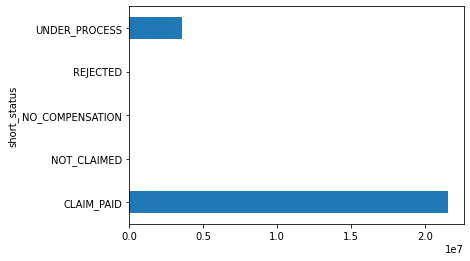

In [1235]:
df_master.groupby(['short_status'])['refund_amount'].sum().round(2).plot(kind='barh')

In [1231]:
df_master.groupby(['short_status'])['car_id'].count()

short_status
CLAIM_PAID          7824
NOT_CLAIMED        50530
NO_COMPENSATION     4180
REJECTED            4755
UNDER_PROCESS       2262
Name: car_id, dtype: int64

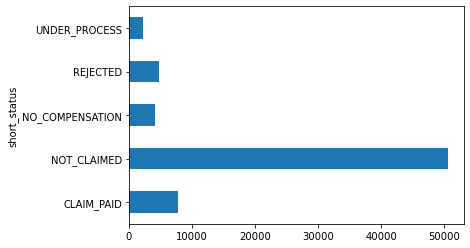

In [1236]:
df_master.groupby(['short_status'])['car_id'].count().plot(kind='barh')